# Weighting events when training ML algorithms for classification problems

- a run down of the main considerations
- quantify the effects of different weighting strategies on discovery significance
     - using dataset from Kaggle Higgs ML challenge in 2014
     
- ideas/thoughts on how to squeeze more significance out of the NN discriminator

# How do we weight MC events in general?

- we generally want our final histogram bins to represent **how many events we expect to see in the data**

-  therefore the final weight must include:
   - the cross section of the process, the luminosity
   - weights (sometimes negative) produced by the MC generator to yield a physical prediction
   - weights that correct for known deficiences in the simulation, e.g. b-tagging or trigger scale factors
   
$$ w_{final}  = \sigma * \mathcal{L} * (w_{trigger} * w_{b-tagging} \dots etc.) $$

# What about when we are training an ML algorithm?

- **optimally**, we want our training simulation to represent **how we expect our data to look**

-  therefore the training simulation should include:
   - the cross section of the process, ~~the luminosity of the dataset~~
   - weights (sometimes negative) produced by the MC generator to yield a physical prediction
   - weights that correct for known deficiences in the simulation, e.g. b-tagging or trigger scale factors 

# In the case of a rare signal, this can lead to an undeperforming algorithm!


- The NN output, $p(x)$, is the predicted probability for the S, B classes ($t = 1,0$)
- Training NN minimises the **loss function**.  
- The **loss function** is usually the *binary cross-entropy*:
$$ C = \sum_i - \big[ ( t* \ln p(x_i))  + (1-t)*(1- \ln p(x_i) ) \big]$$

In [56]:
import matplotlib
matplotlib.rcParams['font.size'] = 16
import matplotlib.pyplot as plt
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense

In [57]:
%time
df = pd.read_csv("atlas-higgs-challenge-2014-v2.csv")
df

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.240,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.000,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,1.904263,b,t,6.245333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,...,1.190,-0.766,41.791,0.787,-1.090,154.056,0.005721,s,u,0.259892
818234,918234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,...,1.293,-0.868,70.158,-2.018,2.893,178.856,0.000461,s,u,0.020956
818235,918235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,...,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,1.189365,b,u,53.284258
818236,918236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,...,1.460,2.637,-999.000,-999.000,-999.000,30.863,0.512740,b,u,22.971060


In [59]:
listSigs = []

Labels=df['Label']

lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(Labels)
features = df.iloc[:,1:31]

X=features
y=np.ravel(labels)

print("Number of signal events = " + str(np.count_nonzero(y == 1)))
print("Number of background events = " + str(np.count_nonzero(y == 0)))

weights = df['Weight']
weights=np.ravel(weights)

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.33, random_state=42, shuffle=True)

Number of signal events = 279560
Number of background events = 538678


# weighting strategies
- 1. **ignore weights altogether**: 
     - the relative contribution of the S and B classes to the loss function will depend on how many MC events of each class you generated!! ¯\_(ツ)_/¯
     - relative contributions of processes within mixed background class won't correspond to the SM! ¯\_(ツ)_/¯
- 2. **use $w_{final}$**: events contribute to the loss function according to their probablity
   - theoretically correct *weighted mixture* of processes for the background class
   - but rare signal hardly contributes to the loss function at all! 
   - classifying $\approx$ everything as background would give $\approx$ 100% accuracy
- 3. **use $w_{final}$: but give signal events a final constant weight such that** $$\sum w^b_i = \sum w^s_i$$

In [70]:
# option 1 (each event gets weight = 1.0) 
#final_weights_train = np.ones(len(weights_train)) 

# option 2 (take weights from the MC generator)
final_weights_train = weights_train  

# option 3 (take weights from the MC generator, but give uniform weight to signal class to equalise sum of weights
#takes some manipulation!) 

#df_train = pd.DataFrame()
# df_train["label"] = y_train
# df_train["weights"] = weights_train

# sigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])
# bkgSumWeights = np.sum(df_train[df_train["label"]==0]["weights"])

# scale = (bkgSumWeights/sigSumWeights)
# df_train.loc[df_train.label==1, "weights"] *= scale

# modsigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])

# #print(bkgSumWeights)
# #print(sigSumWeights)
# #print(scale)
# #print(modsigSumWeights)

# final_weights_train = df_train["weights"]

In [78]:
model = Sequential()
model.add(Dense(15, input_dim=30, activation='relu', kernel_regularizer=None))
model.add(Dense(15, activation='relu', kernel_regularizer=None))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')   
model.fit(X_train, y_train, sample_weight=final_weights_train, epochs=8, batch_size=100, verbose=1)

Epoch 1/12
548219/548219 [==============================] - 5s 10us/step - loss: 0.0141
Epoch 2/12
548219/548219 [==============================] - 5s 9us/step - loss: 0.0070
Epoch 3/12
548219/548219 [==============================] - 5s 9us/step - loss: 0.0059
Epoch 4/12
548219/548219 [==============================] - 5s 8us/step - loss: 0.0055
Epoch 5/12
548219/548219 [==============================] - 5s 8us/step - loss: 0.0053
Epoch 6/12
548219/548219 [==============================] - 4s 8us/step - loss: 0.0052
Epoch 7/12
548219/548219 [==============================] - 4s 8us/step - loss: 0.0051
Epoch 8/12
548219/548219 [==============================] - 5s 8us/step - loss: 0.0051
Epoch 9/12
548219/548219 [==============================] - 5s 8us/step - loss: 0.0050
Epoch 10/12
548219/548219 [==============================] - 6s 11us/step - loss: 0.0050
Epoch 11/12
548219/548219 [==============================] - 5s 9us/step - loss: 0.0050
Epoch 12/12
548219/548219 [============

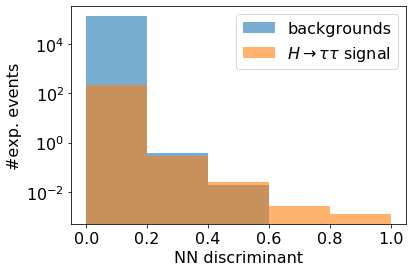

In [75]:
pred_test = model.predict(X_test)

df = pd.DataFrame()
df["labels"] = y_test
df["predictions"] = pred_test
df["weights"] = weights_test

signalVals = df[df['labels']== 1] 
backgroundVals = df[df['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHist = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHist = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
plt.yscale('log')
plt.show()

In [76]:
#extract sig vs. discriminant.
bins = sigHist[1]
nSig = sigHist[0]
nBkg = bkgHist[0]

binCentres = (bins[:-1] + bins[1:]) / 2
width = bins[1] - bins[0]
sigmas = np.array([])

for x in range(0,len(binCentres)):
    indices = [x, (len(binCentres)-1)] 
    if (nBkg[indices].sum() != 0):
        sigma = (nSig[indices].sum()) / (     np.sqrt(nBkg[indices].sum() + nBkg[indices].sum() )   )
    else:
        sigma = 1.0
    sigmas = np.append(sigmas, sigma)
    
listSigs.append(sigmas)

IndexError: list index out of range

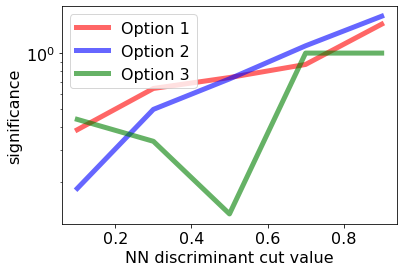

In [77]:
#make comparison plot
fig, ax1 = plt.subplots()
plt.xlabel("NN discriminant cut value")
plt.ylabel("significance")
plt.yscale('log')

labels = ["Option 1", "Option 2", "Option 3"]
styles = ["r-", "b-", "g-"]

for h in range(0, len(listSigs)):
    ax1.plot(binCentres, listSigs[h], styles[h], label=labels[h], lw=5, alpha=0.6)
    plt.legend()
    
plt.show()

- 4. **weight such that minimises loss function optimises the final result, e.g. discovery significance**
   - even possible with weights? easier to define a specific loss function, e.g., $ L = \frac{s}{\sqrt{s+b}}$
   - could be worthwhile if systematic effect matters, e.g, down-weight events that contribute more to systematics...